# Assembling data for the Hyades

In [276]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from tqdm import tqdm

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [277]:
def convert_hours_to_degrees(df, ra_name, dec_name):
    RA, DE = [], [] #[np.zeros(len(douglas)) for i in range(2)]
    for i in range(len(df)):     
        coords = "{0} {1}".format(df[ra_name].values[i], df[dec_name].values[i])
        c = SkyCoord(coords, unit=(u.hourangle, u.deg))
        RA.append(c.ra.degree)
        DE.append(c.dec.degree)
    df["ra"] = RA
    df["dec"] = DE
    return df

# Douglas rotation periods

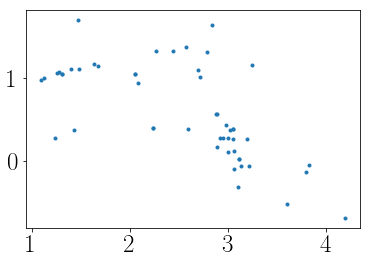

In [278]:
douglas = pd.read_csv("../data/hyades.csv")
m = 0 < douglas.prot.values
plt.plot(douglas.bp[m] - douglas.rp[m], np.log10(douglas.prot[m]), ".")

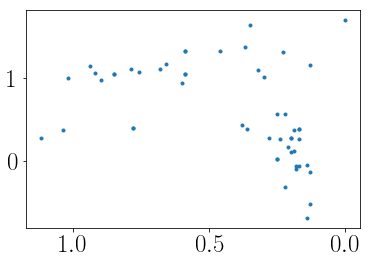

In [279]:
mass = []
for i, ma in enumerate(douglas.Mass.values):
    try:
        mass.append(float(ma))
    except:
        mass.append(0.)
douglas["mass"] = np.array(mass)
plt.plot(douglas.mass.values[m], np.log10(douglas.prot.values[m]), ".")
plt.gca().invert_xaxis()

Combine Douglas, Delorme and Radick (still need to add Hartman, Prosser and ASAS).

# Delorme

In [340]:
de = pd.read_csv("../data/hyades_delorme.csv", skiprows=70)
delorme = pd.DataFrame(dict({
                             "prot": de.Per,
                             "J-Ks": de["J-Ks"],
                             "Ks": de.Ksmag,
                             "vmag": de.Vmag,
                             "B-V": de["B-Vl"],
                             "ra": de._RA,
                             "dec": de._DE
                              }))

In [334]:
radick87= pd.read_csv("../data/hyades_radick_1987.csv")
radick95= pd.read_csv("../data/hyades_radick_1995.csv")

# Hartman

In [335]:
ha = pd.read_csv("../data/hartman.csv", skiprows=76)
ha = convert_hours_to_degrees(ha, "RAJ2000", "DEJ2000")
hartman = pd.DataFrame(dict({"ra": ha.ra, "dec": ha.dec,
                             "jmag": ha.Jmag,
                             "kmag": ha.Kmag,
                             "hmag": ha.Hmag,
                             "vmag": ha.Vmag,
                             "prot": ha.Pe
}))

In [336]:
from astropy.coordinates import FK5

RAJ2000, DEJ2000 = [], []
for i in range(len(radick87)):
    coord = SkyCoord(radick87.RAJ1950.values[i], radick87.decJ1950.values[i], 
                     unit=(u.hourangle, u.deg), equinox="J1950")
    rd = coord.transform_to(FK5(equinox='J2000'))
    RAJ2000.append(rd.ra.degree)
    DEJ2000.append(rd.dec.degree)

radick87["RAJ2000"] = np.array(RAJ2000)
radick87["DEJ2000"] = np.array(DEJ2000)

Load the gaia crossmatch for the clusters.

In [337]:
gaia = pd.read_csv("../data/gaia_cluster_crossmatch.csv", skiprows=49)
m = gaia.Cluster.values == "Hyades  "
hg = gaia.iloc[m]
hg.head()
hg["source_id"] = hg.Source

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


And Megan Bedell's K2 - Gaia crossmatch.

In [338]:
bedell = pd.read_csv("K2_c4_gaia.csv")

(-1, 36)

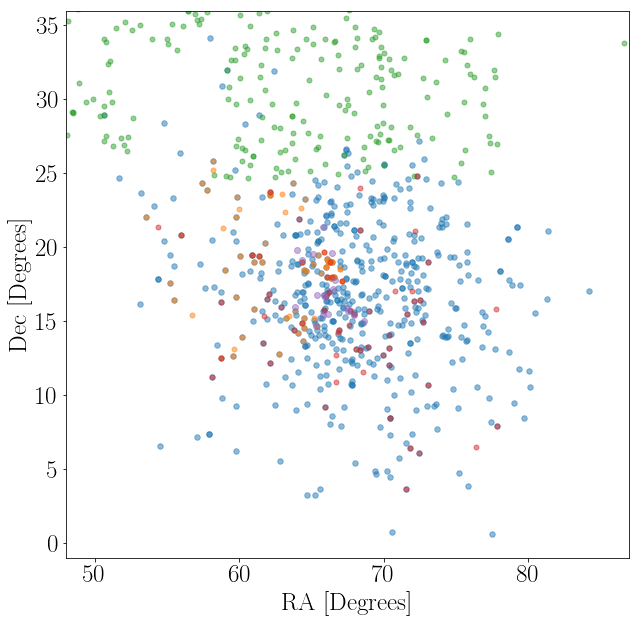

In [341]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(douglas.ra, douglas.dec, s=25, zorder=1, alpha=.5)
plt.scatter(hartman.ra, hartman.dec, s=25, zorder=2, alpha=.5)
plt.scatter(delorme.ra, delorme.dec, s=25, zorder=3, alpha=.5)
plt.scatter(radick87.RAJ2000, radick87.DEJ2000, zorder=4, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

Find closest matches between Gaia and other catalogues.

In [342]:
def find_min_dist(ra1, dec1, ra2, dec2, dist_arcsecs=5.):
    """
    ind1 is a list of indices the same length as ra1 and dec1 that identifies matching stars in ra1 and dec1.
    ind2 is a list of indices the same length as ra2 and dec2 that identifies matching stars in ra2 and dec2.
    """
    closest_ra, closest_dec, distance, ind1, ind2 = [], [], [], [], []
    for i in tqdm(range(len(ra1))):
        e2 = np.sqrt((ra2.values - ra1.values[i])**2 + (dec2.values - dec1.values[i])**2)
        min_distance = min(e2)
        if min_distance < dist_arcsecs/3600.:
            m = e2 == min_distance
            if sum(m) > 1:
                m = np.arange(len(ra2))[m[0]]
            closest_ra.append(ra1.values[i])
            closest_dec.append(dec1.values[i])
            distance.append(min_distance)
            ind1.append(i)
            ind2.append(np.arange(len(ra2))[m])
            
    m1, m2 = np.zeros(len(ra1), dtype="bool"), np.zeros(len(ra2), dtype="bool")
    for i in ind1:
        m1[i] = True
    for i in ind2:
        m2[i] = True
    return m1, m2

# Gaia and Hartman

Hartman has J, H and K colors, V-band magnitudes, and the rotation period column is "Pe".

(-1, 36)

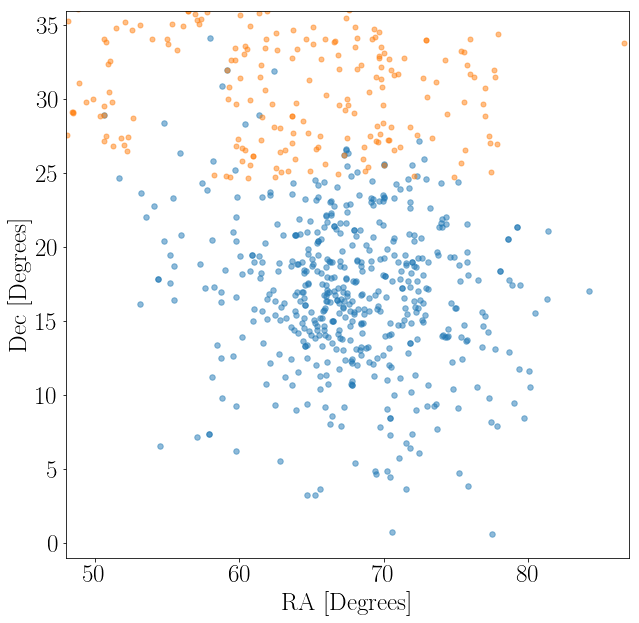

In [343]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(hartman.ra, hartman.dec, s=25, zorder=1, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

Find the closest stars

In [344]:
ind1, ind2 = find_min_dist(hg.RA_ICRS, hg.DE_ICRS, hartman.ra, hartman.dec)
print(sum(ind1), sum(ind2), "matches")

100%|██████████| 515/515 [00:00<00:00, 2826.56it/s]

4 4 matches


Text(0,0.5,'dec')

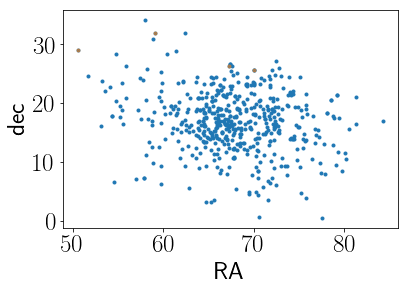

In [345]:
plt.plot(hg.RA_ICRS, hg.DE_ICRS, ".")
plt.plot(hg.RA_ICRS.values[ind1], hg.DE_ICRS.values[ind1], ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("dec")

Now add the Hartman catalogue on to the Douglas catalogue.

In [349]:
hg.iloc[ind1]

Source   Cluster   RA_ICRS   DE_ICRS    Gmag     plx  e_plx  \
254  119219294181874048  Hyades    50.63270  28.97455  13.858  20.868  0.015   
443  148183866430358016  Hyades    70.03892  25.59213  10.089  22.591  0.033   
464  151312419393052032  Hyades    67.29628  26.24652  12.065  20.933  0.010   
475  168774798644094592  Hyades    59.13855  31.95661  12.733  20.630  0.039   

     _RA.icrs  _DE.icrs           source_id  
254  50.63270  28.97455  119219294181874048  
443  70.03892  25.59213  148183866430358016  
464  67.29628  26.24652  151312419393052032  
475  59.13855  31.95661  168774798644094592

In [350]:
hartman.iloc[ind2]

dec    hmag    jmag   kmag        prot         ra    vmag
1566  28.974778  10.195  10.823  9.939    1.925813  50.631917  15.175
1581  31.956889   9.188   9.795  8.944              59.137833  14.122
1885  25.592417   7.583   8.168  7.385    5.620124  70.038375  10.626
1886  26.246806   9.038   9.680  8.827   18.316511  67.295708  12.889

In [363]:
hart_gaia = hartman.iloc[ind2]
hart_gaia["source_id"] = hg.iloc[ind1].source_id.values

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [367]:
df1 = pd.merge(douglas, hart_gaia, how="outer")
df1.prot
print(np.shape(douglas), np.shape(hart_gaia), np.shape(df1))

(73, 38) (4, 8) (77, 42)


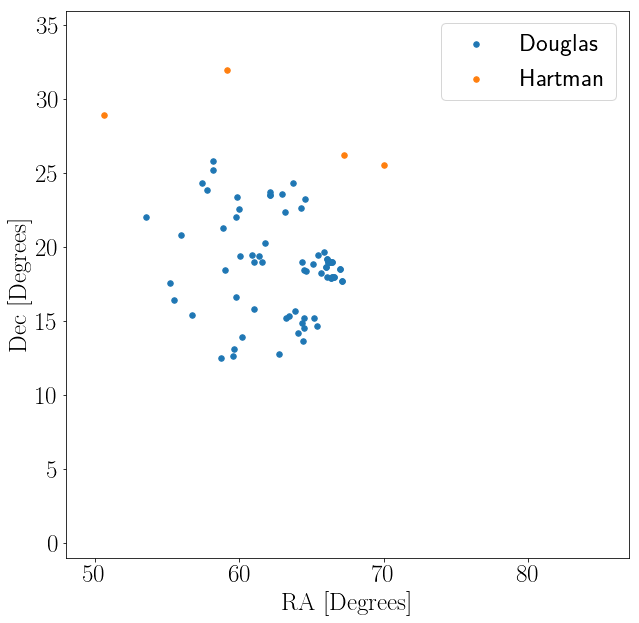

In [368]:
plt.figure(figsize=(width*f, height*f))
plt.scatter(df1.iloc[:73].ra, df1.iloc[:73].dec, s=30, zorder=0, label="Douglas")
plt.scatter(df1.iloc[73:].ra, df1.iloc[73:].dec, s=30, zorder=1, label="Hartman")
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)
plt.legend()

# Gaia and Delorme

Delorme has J-Ks colour, V-band magnitudes and the Period column is called "Per".

In [369]:
delorme.head()

B-V   J-Ks    Ks       dec   prot        ra   vmag
0   0.92  0.524  7.12  21.34317  10.57  54.39571   9.30
1   0.90  0.871  9.61  20.86011  12.30  55.94612       
2   1.54  0.858  9.01  11.26072  13.29  58.14296       
3   1.58  0.905  9.06  16.31564   6.04  58.72167       
4   1.07  0.607  7.57  12.48558  11.66  58.75596  10.00

In [ ]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(delorme.ra, delorme.dec, s=25, zorder=1, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

print(len(hg.source_id.values), len(np.unique(hg.source_id.values)))

Find the closest stars.

In [373]:
ind1, ind2 = find_min_dist(hg.RA_ICRS, hg.DE_ICRS, delorme.ra, delorme.dec)
print(sum(ind1), sum(ind2), "matches")

100%|██████████| 515/515 [00:00<00:00, 12545.32it/s]

47 45 matches


Text(0,0.5,'dec')

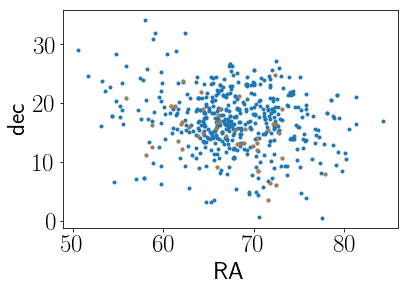

In [374]:
plt.plot(hg.RA_ICRS, hg.DE_ICRS, ".")
plt.plot(hg.RA_ICRS.values[ind1], hg.DE_ICRS.values[ind1], ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("dec")

Add Delorme to the catalogue.

In [379]:
de_gaia = delorme.iloc[ind2]

In [378]:
de_gaia["source_id"] = hg.iloc[ind1].source_id.values


ValueError: Length of values does not match length of index

In [376]:
df2 = pd.merge((df1, de_gaia), how="outer")
print(np.shape(df1), np.shape(delorme_gaia), np.shape(df2))

ValueError: Length of values does not match length of index

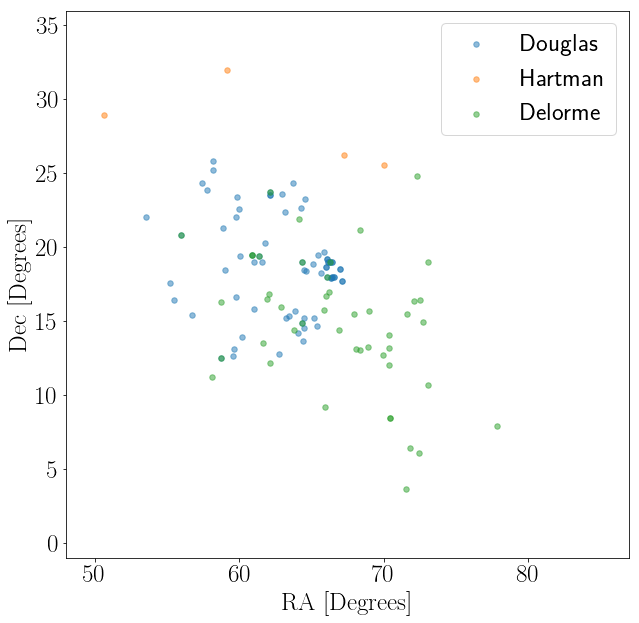

In [298]:
plt.figure(figsize=(width*f, height*f))
plt.scatter(df2.iloc[:73].ra, df2.iloc[:73].dec, s=30, zorder=0, alpha=.5, label="Douglas")
plt.scatter(df2.iloc[73:77].ra, df2.iloc[73:77].dec, s=30, zorder=1, alpha=.5, label="Hartman")
plt.scatter(df2.iloc[77:124].ra, df2.iloc[77:124].dec, s=30, zorder=2, alpha=.5, label="Delorme")
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)
plt.legend()

In [299]:
df2.head()

2M             2MASS       Amp   Ap B-Vl  Bin Bl Cluster      DEJ2000  \
0  NaN  03341053+2204213  0.008264  4.0  NaN  2.0  N     NaN  +22 04 21.2   
1  NaN  03404581+1734477  0.020289  3.0  NaN  0.0  N     NaN  +17 34 47.7   
2  NaN  03420441+1625183  0.158637  2.0  NaN  0.0  Y     NaN  +16 25 18.3   
3  NaN  03434706+2051363  0.014581  2.5  NaN  0.0  N     NaN  +20 51 36.4   
4  NaN  03465952+1524170  0.005815  4.0  NaN  2.0  N     NaN  +15 24 16.8   

   DE_ICRS  ...   plxdelorme  pmDE  pmRA     prot r_Vmag         ra    ra_err  \
0      NaN  ...          NaN   NaN   NaN   1.8088    NaN  53.544861  0.084542   
1      NaN  ...          NaN   NaN   NaN        0    NaN  55.191643  0.114236   
2      NaN  ...          NaN   NaN   NaN        0    NaN  55.519163  0.088386   
3      NaN  ...          NaN   NaN   NaN  12.3168    NaN  55.946823  0.056599   
4      NaN  ...          NaN   NaN   NaN   0.8584    NaN  56.749149  0.143451   

          rp          source_id   use  
0  13.300308  64552022725337856  corr  
1  14.877822  44388010264995200  corr  
2  13.567423  44052178182130816  corr  
3  12.140936  63395989328447232  corr  
4  12.665202  42947680095257344  corr  

[5 rows x 85 columns]

In [300]:
# for i in df2.keys():
#     print(i)

55 124


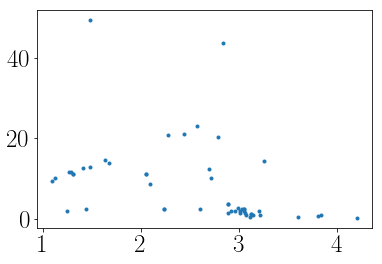

In [301]:
m = df2.prot.values > 0.
plt.plot(df2.bp.values[m] - df2.rp.values[m], df2.prot.values[m], ".")
print(len(df2.prot.values[m]), len(df2))

In [302]:
# print(df2.source_id.values)
source_ids_hyades = pd.DataFrame(dict({"source_id": df2.source_id}))
source_ids_hyades.to_csv("../data/source_ids_hyades.csv")

After performing the following query with the above data file uploaded:

SELECT *

FROM user_table_name

JOIN gaiadr2.gaia_source AS gaia USING (source_id)

In [303]:
gaia_h = pd.read_csv("../data/hyades-result.csv")
gaia_h.head()

table2_oid  col1          solution_id                 designation  \
0           1     0  1635721458409799680  Gaia DR2 64552022725337856   
1           2     1  1635721458409799680  Gaia DR2 44388010264995200   
2           3     2  1635721458409799680  Gaia DR2 44052178182130816   
3           4     3  1635721458409799680  Gaia DR2 63395989328447232   
4           5     4  1635721458409799680  Gaia DR2 42947680095257344   

   random_index  ref_epoch         ra  ra_error        dec  dec_error  \
0     805628475     2015.5  53.544861  0.084542  22.072399   0.062352   
1     350324408     2015.5  55.191643  0.114236  17.579829   0.088322   
2     120803872     2015.5  55.519163  0.088386  16.421655   0.059111   
3     378490312     2015.5  55.946823  0.056599  20.859947   0.038860   
4     283438101     2015.5  56.749149  0.143451  15.404583   0.082477   

         ...          flame_flags  radius_val  radius_percentile_lower  \
0        ...                  NaN         NaN                      NaN   
1        ...                  NaN         NaN                      NaN   
2        ...                  NaN         NaN                      NaN   
3        ...                  NaN         NaN                      NaN   
4        ...                  NaN         NaN                      NaN   

   radius_percentile_upper  lum_val  lum_percentile_lower  \
0                      NaN      NaN                   NaN   
1                      NaN      NaN                   NaN   
2                      NaN      NaN                   NaN   
3                      NaN      NaN                   NaN   
4                      NaN      NaN                   NaN   

   lum_percentile_upper                                       datalink_url  \
0                   NaN  http://geadata.esac.esa.int/data-server/datali...   
1                   NaN  http://geadata.esac.esa.int/data-server/datali...   
2                   NaN  http://geadata.esac.esa.int/data-server/datali...   
3                   NaN  http://geadata.esac.esa.int/data-server/datali...   
4                   NaN  http://geadata.esac.esa.int/data-server/datali...   

   epoch_photometry_url          source_id  
0                   NaN  64552022725337856  
1                   NaN  44388010264995200  
2                   NaN  44052178182130816  
3                   NaN  63395989328447232  
4                   NaN  42947680095257344  

[5 rows x 98 columns]

In [304]:
df3 = pd.merge(df2, gaia_h, on="source_id")

In [305]:
print(np.shape(df3))

(164, 182)


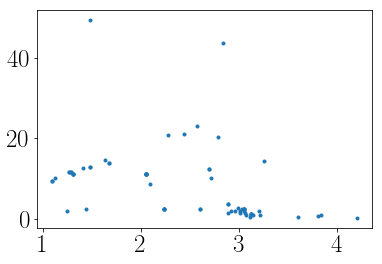

In [307]:
m = 0 < df3.prot.values 
plt.plot(df3.bp[m] - df3.rp[m], df3.prot.values[m], ".")